In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("resume.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


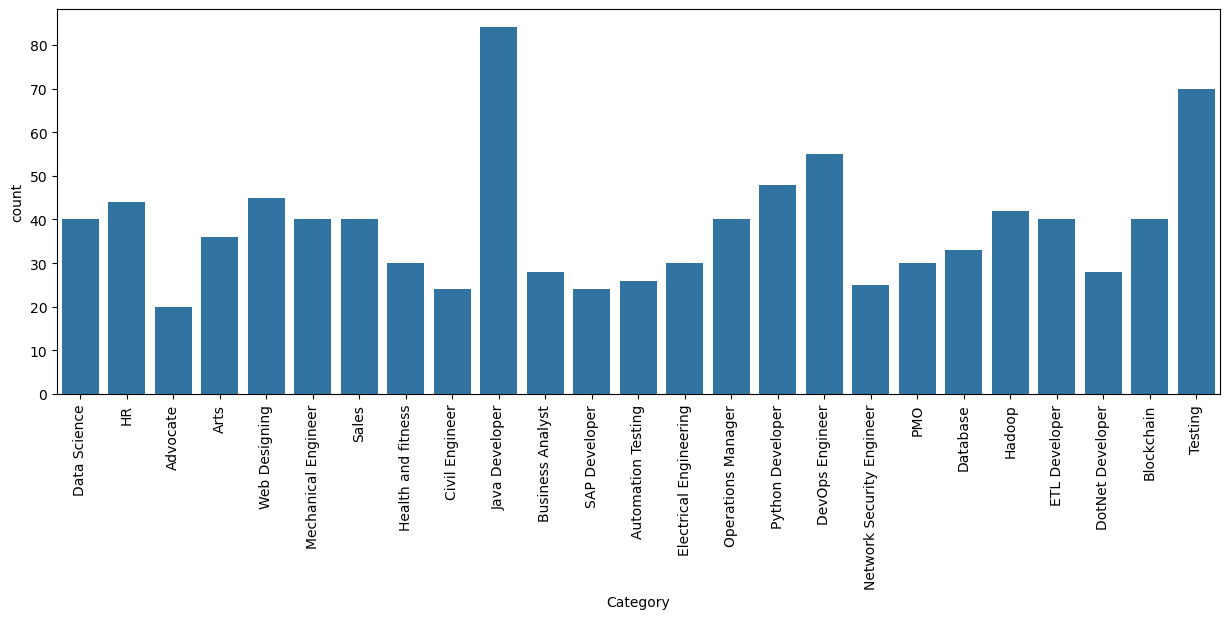

In [4]:
plt.figure(figsize=(15,5))
sns.countplot(x=df['Category'])
plt.xticks(rotation = 90)
plt.show()

In [5]:
# Get the largest category size (i.e., the category with the maximum number of entries)
max_size = df['Category'].value_counts().max()

# Perform oversampling
balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)

# Shuffle the dataset to avoid any order bias
df = balanced_df.sample(frac=1).reset_index(drop=True)

# Check the balanced category distribution
print("\nBalanced Category Distribution (After Oversampling):")
print(df['Category'].value_counts())


Balanced Category Distribution (After Oversampling):
Category
Hadoop                       84
Business Analyst             84
Python Developer             84
Automation Testing           84
Sales                        84
SAP Developer                84
Testing                      84
DevOps Engineer              84
Database                     84
Electrical Engineering       84
PMO                          84
Arts                         84
ETL Developer                84
Network Security Engineer    84
Mechanical Engineer          84
Data Science                 84
Health and fitness           84
Web Designing                84
DotNet Developer             84
Java Developer               84
Blockchain                   84
HR                           84
Operations Manager           84
Advocate                     84
Civil Engineer               84
Name: count, dtype: int64


In [6]:
import re
def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)  
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText) 
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText

In [7]:
df['Resume'] = df['Resume'].apply(lambda x: cleanResume(x))

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [9]:
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

In [10]:
df.Category.unique()

array([13, 17,  0, 18, 12,  3, 15,  9, 24, 14,  6, 16, 10,  4,  1, 19, 11,
        7,  8, 23, 21, 22,  2, 20,  5])

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(df['Resume'])
requiredText  = tfidf.transform(df['Resume'])

In [12]:
requiredText.shape

(2100, 7351)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(requiredText, df['Category'], test_size=0.2, random_state=101)

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [15]:
# cv_svc = LinearSVC()
# grid_svc_param = {'penalty' : ['l1','l2'],
#                   'dual' : ['auto'],
#                   'C' : [0.5 , 1 , 1.5 , 2 , 3 , 5],
#                  }
# model_cv_svc = GridSearchCV(cv_svc , param_grid=grid_svc_param , scoring='f1' , verbose=2 , cv=10)
# model_cv_svc.fit(X_train , y_train)
# model_cv_svc.best_params_

In [16]:
svc_model = LinearSVC(C = 0.5, dual = 'auto', penalty = 'l1')
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print("\nSVC Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svc)}")


SVC Results:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        16
          16       1.00    

In [17]:
def prediction(input_resume):
    # Preprocess the input text (e.g., cleaning, etc.)
    cleaned_text = cleanResume(input_resume) 

    # Vectorize the cleaned text using the same TF-IDF vectorizer used during training
    vectorized_text = tfidf.transform([cleaned_text])
    
    # Convert sparse matrix to dense
    vectorized_text = vectorized_text.toarray()

    # Prediction
    predicted_category = svc_model.predict(vectorized_text)

    # get name of predicted category
    predicted_category_name = le.inverse_transform(predicted_category)

    return predicted_category_name[0]  # Return the category name

In [18]:
from joblib import load , dump
dump(svc_model , "resume.joblib")
dump(tfidf , "tfidf.joblib")
dump(le , "le.joblib")

['le.joblib']